In [ ]:
%load_ext autoreload
%autoreload 2
import numpy as np
import get_data
import matplotlib.pyplot as plt
import population_activity as pop
import helper_functions as hf
import analysis
import plots
import statistics_test as st

from IPython.display import display, HTML
def print_large(text):
    display(HTML(f"<span style='font-size: 20px;'>{text}</span>"))
    

c:\Users\Ole\anaconda3\envs\spyder-env\lib\site-packages\outdated\utils.py:14: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.5.3, the latest is 0.5.5.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(


In [2]:
def analyze_data_common(datapath, reference, maps, analysis_type, method='subspace', compute_day11_12=False, 
                        transients=False, dim_red=False, max_dim=4, standardize='stand'):
    def get_analysis_function(analysis_type):
        if analysis_type == 'population_geometry':
            return analysis.populationgeometry, analysis.populationgeometry_context
        elif analysis_type == 'topology':
            return analysis.topology_analysis, analysis.topology_analysis_context

    analysis_func, context_func = get_analysis_function(analysis_type)

    def apply_analysis(func, *args):
        if analysis_type == 'population_geometry':
            return func(*args, method=method)
        else:
            return func(*args, max_dim=max_dim)

    hists = analysis.sort_maps_from_reference_AK(datapath, 'Context1', reference=reference, maps=maps, 
                                                 reference_type='no_reference', hist='hist', transients=transients, 
                                                 dim_red=dim_red, standardize=standardize, remove_day_inactive=False)
    g = apply_analysis(analysis_func, hists)
    hists_2 = analysis.sort_maps_from_reference_AK(datapath, 'Context2', reference=reference, maps=maps, 
                                                   reference_type='no_reference', hist='hist', transients=transients,
                                                     dim_red=dim_red, standardize=standardize, remove_day_inactive=False)
    g_2 = apply_analysis(analysis_func, hists_2)

    global_seeds = [1,2,3,4,5]
    simu_g_list = []
    for seed in global_seeds:
        simu_drift = analysis.simulate_drift(datapath, session='0', Context='Context1', days=len(maps)+1, drift_type='circular', 
                                             dim_red=dim_red, standardize=standardize, odd_even=True, global_seed=seed, 
                                             active_days=[reference]+maps, remove_day_inactive=True,
                                             max_remap_prob=0.3, amplitude_drift_prob=0.3, amplitude_change_scale=0.5)
        simu_g = apply_analysis(analysis_func, simu_drift['maps'])
        simu_g_list.append(simu_g)
    simu_g_array = np.array(simu_g_list)
    simu_g = np.mean(simu_g_array, axis=0)

    hist_odd, hist_even = analysis.sort_maps_from_reference_within_session_AK(datapath, 'Context1', maps=maps, 
                                                                                  transients=transients, dim_red=dim_red, standardize=standardize, 
                                                                                  remove_day_inactive=False)
    g_odd_even1 = apply_analysis(context_func, hist_odd, hist_even)
    hist_odd, hist_even = analysis.sort_maps_from_reference_within_session_AK(datapath, 'Context2', maps=maps, transients=transients, dim_red=dim_red, standardize=standardize, remove_day_inactive=False)
    g_odd_even2 = apply_analysis(context_func, hist_odd, hist_even)

    if analysis_type == 'population_geometry':              
        shuff1, shuff2 = analysis.shuffle_two_sessions_hist(datapath, '0', '19', 'Context1', dim_red=dim_red, remove_inactive=[reference]+maps, 
                                                            standardize=standardize, remove_day_inactive=False)
        shuff1_con2, shuff2_con2 = analysis.shuffle_two_sessions_hist(datapath, '0', '19', 'Context2', dim_red=dim_red, remove_inactive=[reference]+maps, 
                                                                      standardize=standardize, remove_day_inactive=False)
        g_shuff1 = apply_analysis(context_func, [shuff1], [shuff2])
        g_shuff2 = apply_analysis(context_func, [shuff1_con2], [shuff2_con2])
        
        g = (g - np.mean(g_odd_even1)) / (np.mean(g_shuff1) - np.mean(g_odd_even1))
        g_2 = (g_2 - np.mean(g_odd_even2)) / (np.mean(g_shuff2) - np.mean(g_odd_even2))
        simu_g = (simu_g - np.mean(g_odd_even1)) / (np.mean(g_shuff1) - np.mean(g_odd_even1))
    else:
        g = g-g_odd_even1
        g_2 = g_2-g_odd_even2
        simu_g = simu_g-g_odd_even1

    if compute_day11_12:
        hists_day11 = [h for h, m in zip(hists, maps) if m == '17']
        hists_day12 = [h for h, m in zip(hists, maps) if m == '19']
        hists_2_day12 = [h for h, m in zip(hists_2, maps) if m == '19']

        g_day11_12_context1 = apply_analysis(context_func, hists_day11, hists_day12)
        g_day12_contexts = apply_analysis(context_func, hists_day12, hists_2_day12)

        if analysis_type == 'population_geometry':
            hist_odd_1, hist_even_1 = analysis.sort_maps_from_reference_within_session_AK(datapath, 'Context1', maps=['12'], 
                                                                                          transients=transients, dim_red=dim_red, 
                                                                                          standardize=standardize, remove_day_inactive=False)
            g_odd_even_1 = apply_analysis(context_func, hist_odd_1, hist_even_1)
            g_shuff_11_12 = apply_analysis(context_func, [shuff2], [shuff2_con2])

            g_day12_contexts_norm = (g_day12_contexts - g_odd_even_1) / (np.mean(g_shuff_11_12) - g_odd_even_1)
            g_day11_12_context1_norm = (g_day11_12_context1 - g_odd_even_1) / (np.mean(g_shuff_11_12) - g_odd_even_1)
        else:
            g_day12_contexts_norm = g_day12_contexts
            g_day11_12_context1_norm = g_day11_12_context1

        return g, g_2, simu_g, g_day12_contexts_norm, g_day11_12_context1_norm
    else:
        return g, g_2, simu_g


def collect_data(datapaths, reference, maps, analysis_type, method='subspace', compute_day11_12=False, 
                 transients=False, dim_red=False, max_dim=4, standardize='stand'):
    all_data = []
    for datapath in datapaths:
        data = analyze_data_common(datapath, reference, maps, analysis_type, method=method, compute_day11_12=compute_day11_12, 
                                   transients=transients, dim_red=dim_red, max_dim=max_dim, standardize=standardize)
        all_data.append(data)
    return all_data

if __name__ == "__main__":
    datapaths = ['D:/Antje_CA1/data_sig/170.h5', 'D:/Antje_CA1/data_sig/51004.h5', 'D:/Antje_CA1/data_sig/51007.h5',
                  'D:/Antje_CA1/data_sig/63.h5', 'D:/Antje_CA1/data_sig/64.h5', 'D:/Antje_CA1/data_sig/65.h5']
    transients = False
    dim_red = False
    max_dim = 4

    reference = '0'
    maps = [str(i) for i in np.arange(1, 13)] +  ['14', '15', '17', '19']
    forward_data_pop_geometry_subspace = collect_data(datapaths, reference, maps, 'population_geometry', method='subspace',
                                                       compute_day11_12=True, transients=transients, dim_red=dim_red, standardize='stand')
    forward_data_pop_geometry_angles = collect_data(datapaths, reference, maps, 'population_geometry', method='angles', 
                                                    compute_day11_12=True, transients=transients, dim_red=dim_red, standardize='stand')
    forward_data_topology = collect_data(datapaths, reference, maps, 'topology', compute_day11_12=True, 
                                         transients=transients, dim_red=dim_red, max_dim=max_dim, standardize='stand')

    reference_reverse = '19'
    maps_reverse =  ['17', '15', '14'] + [str(i) for i in np.arange(12, -1, -1)]
    reverse_data_pop_geometry_subspace = collect_data(datapaths, reference_reverse, maps_reverse, 'population_geometry', 
                                                      method='subspace', compute_day11_12=False, transients=transients, dim_red=dim_red,standardize='stand' )
    reverse_data_pop_geometry_angles = collect_data(datapaths, reference_reverse, maps_reverse, 'population_geometry', 
                                                    method='angles', compute_day11_12=False, transients=transients, dim_red=dim_red,  standardize='stand')
    reverse_data_topology = collect_data(datapaths, reference_reverse, maps_reverse, 'topology', 
                                         compute_day11_12=False, transients=transients, dim_red=dim_red, max_dim=max_dim, standardize='stand')

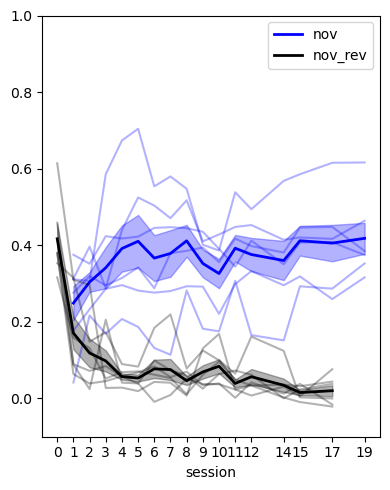

,Source,SS,ddof1,ddof2,MS,F,p-unc,p-GG-corr,ng2,eps
0,time,0.180200,15,75,0.012013,4.292219,1.103644e-05,0.017707,0.098559,0.22333
1,condition,3.734187,1,5,3.734187,28.055926,3.200491e-03,0.003200,0.693786,1.00000
2,time * condition,0.831365,15,75,0.055424,13.237445,1.880298e-15,0.000853,0.335294,0.15129


,Timepoint,Condition 1,Condition 2,Test Used,Statistic,p-value,Adjusted p-value (bonferroni),Significance,Effect Size,Effect Size Type,Mean Cond 1,Mean Cond 2,Mean Diff,SD Diff,N,Normal Dist.,Normality p-value
0,T1,C1,C2,t-test,-3.4477,0.0183,0.2925,,-1.4075,Cohen's d,0.2489,0.4169,-0.1680,0.1194,6,True,0.4301
1,T2,C1,C2,t-test,1.9518,0.1084,1.0000,,0.7968,Cohen's d,0.3039,0.1707,0.1332,0.1672,6,True,0.4502
2,T3,C1,C2,t-test,4.3785,0.0072,0.1146,,1.7875,Cohen's d,0.3413,0.1186,0.2226,0.1246,6,True,0.9233
3,T4,C1,C2,t-test,3.5285,0.0168,0.2683,,1.4405,Cohen's d,0.3915,0.0979,0.2936,0.2038,6,True,0.4185
4,T5,C1,C2,t-test,4.2110,0.0084,0.1344,,1.7191,Cohen's d,0.4104,0.0570,0.3533,0.2055,6,True,0.9568
5,T6,C1,C2,t-test,4.2670,0.0080,0.1274,,1.7420,Cohen's d,0.3664,0.0532,0.3132,0.1798,6,True,0.9067
6,T7,C1,C2,t-test,3.3940,0.0194,0.3100,,1.3856,Cohen's d,0.3786,0.0772,0.3013,0.2175,6,True,0.6413
7,T8,C1,C2,t-test,4.8154,0.0048,0.0771,,1.9659,Cohen's d,0.4116,0.0754,0.3362,0.1710,6,True,0.5656
8,T9,C1,C2,t-test,7.0683,0.0009,0.0140,*,2.8856,Cohen's d,0.3525,0.0463,0.3062,0.1061,6,True,0.0594
9,T10,C1,C2,t-test,4.8143,0.0048,0.0772,,1.9654,Cohen's d,0.3262,0.0692,0.2570,0.1307,6,True,0.5289


,Source,SS,DF,MS,F,p-unc,ng2,eps
0,time,0.820152,15,0.054677,16.075483,1.131602e-17,0.719556,0.175289
1,Error,0.255094,75,0.003401,NaN,NaN,NaN,NaN


,Source,SS,DF,MS,F,p-unc,ng2,eps
0,time,0.191413,15,0.012761,3.559971,0.000127,0.125937,0.192629
1,Error,0.268841,75,0.003585,NaN,NaN,NaN,NaN


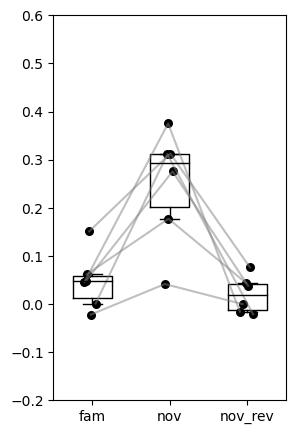

,Source,SS,DF,MS,F,p-unc,ng2,eps
0,time,0.187229,2,0.093615,19.437649,0.000359,0.656149,0.542493
1,Error,0.048161,10,0.004816,NaN,NaN,NaN,NaN


,Timepoint 1,Timepoint 2,Test Used,Statistic,p-value,Adjusted p-value (bonferroni),Significance,Effect Size,Effect Size Type,Mean Diff,SD Diff,Normal Dist.,Normality p-value
0,T1,T2,t-test,-4.6237,0.0057,0.0171,*,-1.8876,Cohen's d,-0.2013,0.1066,True,0.6718
1,T1,T3,t-test,1.9031,0.1154,0.3462,,0.7769,Cohen's d,0.0275,0.0354,True,0.7065
2,T2,T3,t-test,4.3929,0.0071,0.0212,*,1.7934,Cohen's d,0.2288,0.1276,True,0.8806


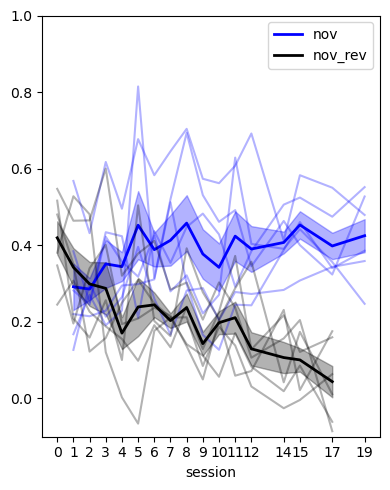

,Source,SS,ddof1,ddof2,MS,F,p-unc,p-GG-corr,ng2,eps
0,time,0.215379,15,75,0.014359,1.276297,0.238533,0.315486,0.067499,0.234243
1,condition,1.497350,1,5,1.497350,12.898201,0.015685,0.015685,0.334767,1.000000
2,time * condition,0.884679,15,75,0.058979,4.628118,0.000004,0.009434,0.229183,0.254958


,Timepoint,Condition 1,Condition 2,Test Used,Statistic,p-value,Adjusted p-value (bonferroni),Significance,Effect Size,Effect Size Type,Mean Cond 1,Mean Cond 2,Mean Diff,SD Diff,N,Normal Dist.,Normality p-value
0,T1,C1,C2,t-test,-1.9200,0.1129,1.0000,,-0.7838,Cohen's d,0.2915,0.4195,-0.1280,0.1633,6,True,0.6250
1,T2,C1,C2,t-test,-0.8064,0.4566,1.0000,,-0.3292,Cohen's d,0.2855,0.3425,-0.0569,0.1729,6,True,0.2663
2,T3,C1,C2,t-test,0.4858,0.6476,1.0000,,0.1983,Cohen's d,0.3513,0.2990,0.0524,0.2639,6,True,0.7645
3,T4,C1,C2,t-test,0.6887,0.5217,1.0000,,0.2811,Cohen's d,0.3442,0.2874,0.0568,0.2019,6,True,0.5652
4,T5,C1,C2,t-test,2.4965,0.0547,0.8755,,1.0192,Cohen's d,0.4524,0.1705,0.2819,0.2766,6,True,0.9563
5,T6,C1,C2,t-test,1.7026,0.1494,1.0000,,0.6951,Cohen's d,0.3885,0.2389,0.1496,0.2152,6,True,0.4786
6,T7,C1,C2,t-test,1.9824,0.1043,1.0000,,0.8093,Cohen's d,0.4130,0.2444,0.1686,0.2083,6,True,0.1775
7,T8,C1,C2,t-test,3.0476,0.0285,0.4560,,1.2442,Cohen's d,0.4578,0.2032,0.2546,0.2046,6,True,0.0933
8,T9,C1,C2,t-test,2.0033,0.1015,1.0000,,0.8178,Cohen's d,0.3772,0.2373,0.1399,0.1710,6,True,0.4018
9,T10,C1,C2,t-test,3.5661,0.0161,0.2578,,1.4558,Cohen's d,0.3423,0.1431,0.1993,0.1369,6,True,0.2823


,Source,SS,DF,MS,F,p-unc,ng2,eps
0,time,0.846348,15,0.056423,4.50341,0.000006,0.421501,0.249999
1,Error,0.939675,75,0.012529,NaN,NaN,NaN,NaN


,Source,SS,DF,MS,F,p-unc,ng2,eps
0,time,0.253710,15,0.016914,1.475306,0.136605,0.122709,0.208599
1,Error,0.859855,75,0.011465,NaN,NaN,NaN,NaN


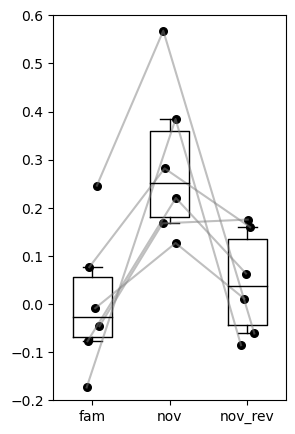

,Source,SS,DF,MS,F,p-unc,ng2,eps
0,time,0.292577,2,0.146288,7.576561,0.009932,0.496058,0.742999
1,Error,0.193080,10,0.019308,NaN,NaN,NaN,NaN


,Timepoint 1,Timepoint 2,Test Used,Statistic,p-value,Adjusted p-value (bonferroni),Significance,Effect Size,Effect Size Type,Mean Diff,SD Diff,Normal Dist.,Normality p-value
0,T1,T2,t-test,-4.7741,0.0050,0.0150,*,-1.9490,Cohen's d,-0.2886,0.1481,True,0.2976
1,T1,T3,t-test,-0.5461,0.6085,1.0000,,-0.2230,Cohen's d,-0.0409,0.1834,True,0.1147
2,T2,T3,t-test,2.4707,0.0565,0.1694,,1.0087,Cohen's d,0.2477,0.2456,True,0.2238


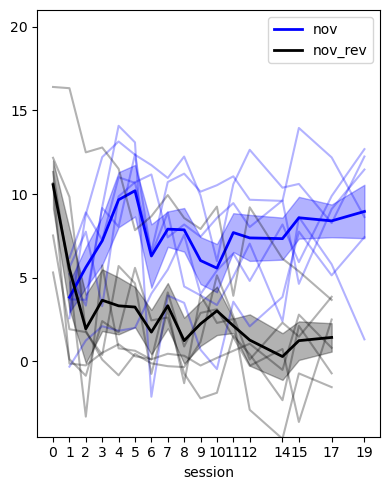

,Source,SS,ddof1,ddof2,MS,F,p-unc,p-GG-corr,ng2,eps
0,time,184.657778,15,75,12.310519,2.105630,0.018442,0.125771,0.072694,0.243791
1,condition,980.726318,1,5,980.726318,5.543953,0.065190,0.065190,0.293957,1.000000
2,time * condition,582.051136,15,75,38.803409,4.651333,0.000003,0.017164,0.198137,0.200177


,Timepoint,Condition 1,Condition 2,Test Used,Statistic,p-value,Adjusted p-value (bonferroni),Significance,Effect Size,Effect Size Type,Mean Cond 1,Mean Cond 2,Mean Diff,SD Diff,N,Normal Dist.,Normality p-value
0,T1,C1,C2,t-test,-2.9161,0.0332,0.5306,,-1.1905,Cohen's d,3.8343,10.5654,-6.7311,5.6540,6,True,0.2741
1,T2,C1,C2,t-test,0.0272,0.9794,1.0000,,0.0111,Cohen's d,5.6197,5.5294,0.0903,8.1440,6,True,0.1933
2,T3,C1,C2,wilcoxon,6.0000,0.4375,1.0000,,0.3852,r,7.2099,1.9471,5.2628,7.8165,6,False,0.0030
3,T4,C1,C2,t-test,1.6049,0.1694,1.0000,,0.6552,Cohen's d,9.6613,3.6571,6.0041,9.1637,6,True,0.1294
4,T5,C1,C2,wilcoxon,2.0000,0.0938,1.0000,,0.7275,r,10.1990,3.3221,6.8769,8.2414,6,False,0.0078
5,T6,C1,C2,t-test,0.9940,0.3659,1.0000,,0.4058,Cohen's d,6.2989,3.2490,3.0499,7.5161,6,True,0.4976
6,T7,C1,C2,t-test,2.9031,0.0337,0.5387,,1.1852,Cohen's d,7.9041,1.7516,6.1525,5.1912,6,True,0.2801
7,T8,C1,C2,t-test,1.8777,0.1192,1.0000,,0.7666,Cohen's d,7.8641,3.3283,4.5358,5.9170,6,True,0.5052
8,T9,C1,C2,t-test,2.1204,0.0875,1.0000,,0.8657,Cohen's d,6.0284,1.2405,4.7879,5.5309,6,True,0.5105
9,T10,C1,C2,t-test,1.4328,0.2113,1.0000,,0.5850,Cohen's d,5.5744,2.2471,3.3273,5.6881,6,True,0.4196


,Source,SS,DF,MS,F,p-unc,ng2,eps
0,time,522.551375,15,34.836758,5.804218,9.751593e-08,0.28925,0.255231
1,Error,450.147948,75,6.001973,NaN,NaN,NaN,NaN


,Source,SS,DF,MS,F,p-unc,ng2,eps
0,time,244.157539,15,16.277169,1.988189,0.027254,0.185572,0.181584
1,Error,614.019871,75,8.186932,NaN,NaN,NaN,NaN


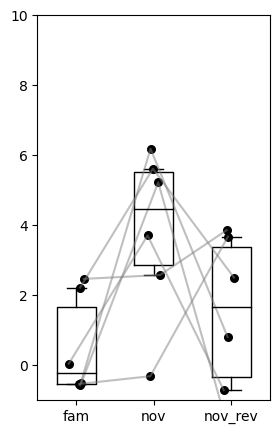

,Source,SS,DF,MS,F,p-unc,ng2,eps
0,time,35.136129,2,17.568064,3.691339,0.063011,0.348896,0.576108
1,Error,47.592658,10,4.759266,NaN,NaN,NaN,NaN


,Timepoint 1,Timepoint 2,Test Used,Statistic,p-value,Adjusted p-value (bonferroni),Significance,Effect Size,Effect Size Type,Mean Diff,SD Diff,Normal Dist.,Normality p-value
0,T1,T2,t-test,-2.9592,0.0315,0.0946,,-1.2081,Cohen's d,-3.3126,2.7420,True,0.4174
1,T1,T3,t-test,-1.1670,0.2958,0.8875,,-0.4764,Cohen's d,-0.9118,1.9139,True,0.4166
2,T2,T3,t-test,1.4108,0.2174,0.6521,,0.5760,Cohen's d,2.4007,4.1682,True,0.4460


In [3]:
# Forward novel subspace
novel = np.vstack([data[1] for data in forward_data_pop_geometry_subspace])
novel_rev = np.vstack([data[1] for data in reverse_data_pop_geometry_subspace])[:, ::-1]

print_large('\n' + '='*50)
print_large('Subspace angles')
print_large('='*50)
fig,ax=plt.subplots(figsize=(4, 5))
plots.plot_average_geometry([novel,novel_rev], maps, directions=[True, False],colors=['b','k'], labels=['nov', 'nov_rev'], plot_individual=True, ylim=[-0.1, 1], ax=ax)
plt.show()  
print_large('\nTWO-WAY REPEATED ANOVA')
anova=st.repeated_measures_anova_general([novel,novel_rev])
display(anova[0])
display(anova[1])

print_large('RM ANOVA: Novel to day 20 (reverse)')
display(st.repeated_measures_anova_single_condition(novel_rev))
print_large('RM ANOVA: Novel to day 1 (forward)')
display(st.repeated_measures_anova_single_condition(novel))

fam = np.vstack([data[0] for data in forward_data_pop_geometry_subspace])
print_large('Comparing novel forward, novel reverse and fammilar day 1')
fig, ax = plt.subplots(figsize=(3, 5))
plots.boxplot_with_points_and_lines(np.vstack([[fam[:,0]],[novel[:,0]],[novel_rev[:,-1]]]).T, ['fam','nov', 'nov_rev'],ax, '',ylim=[-0.2,0.6])
plt.show()  
print_large('RM ANOVA: Novel forward, novel reverse and fammilar day 1')
display(st.repeated_measures_anova_single_condition(np.vstack([[fam[:,0]],[novel[:,0]],[novel_rev[:,-1]]]).T))
print_large('Post hoc: Novel forward, novel reverse and fammilar day 1')
display(st.post_hoc_timepoints([fam[:,0],novel[:,0],novel_rev[:,-1]]))


# Forward novel angles
novel = np.vstack([data[1] for data in forward_data_pop_geometry_angles])
novel_rev = np.vstack([data[1] for data in reverse_data_pop_geometry_angles])[:, ::-1]
print_large('\n' + '='*50)
print_large('Edge angles')
print_large('='*50)
fig,ax=plt.subplots(figsize=(4, 5))
plots.plot_average_geometry([novel,novel_rev], maps, directions=[True, False],colors=['b','k'], labels=['nov', 'nov_rev'], plot_individual=True, ylim=[-0.1, 1], ax=ax)
plt.show()  
print_large('\nTWO-WAY REPEATED ANOVA')
anova=st.repeated_measures_anova_general([novel,novel_rev])
display(anova[0])
display(anova[1])

print_large('RM ANOVA: Novel to day 20 (reverse)')
display(st.repeated_measures_anova_single_condition(novel_rev))
print_large('RM ANOVA: Novel to day 1 (forward)')
display(st.repeated_measures_anova_single_condition(novel))

fam = np.vstack([data[0] for data in forward_data_pop_geometry_angles])
print_large('Comparing novel forward, novel reverse and fammilar day 1')
fig, ax = plt.subplots(figsize=(3, 5))
plots.boxplot_with_points_and_lines(np.vstack([[fam[:,0]],[novel[:,0]],[novel_rev[:,-1]]]).T, ['fam','nov', 'nov_rev'],ax, '',ylim=[-0.2,0.6])
plt.show()  
print_large('RM ANOVA: Novel forward, novel reverse and fammilar day 1')
display(st.repeated_measures_anova_single_condition(np.vstack([[fam[:,0]],[novel[:,0]],[novel_rev[:,-1]]]).T))
print_large('Post hoc: Novel forward, novel reverse and fammilar day 1')
display(st.post_hoc_timepoints([fam[:,0],novel[:,0],novel_rev[:,-1]]))


# Forward novel topology
novel = np.vstack([data[1] for data in forward_data_topology])
novel_rev = np.vstack([data[1] for data in reverse_data_topology])[:, ::-1]
print_large('\n' + '='*50)
print_large('Persistent homology')
print_large('='*50)
fig,ax=plt.subplots(figsize=(4, 5))
plots.plot_average_geometry([novel,novel_rev], maps, directions=[True, False],colors=['b','k'], labels=['nov', 'nov_rev'], plot_individual=True, ylim=[-4.5, 21], ax=ax)
plt.show() 
print_large('\nTWO-WAY REPEATED ANOVA')
anova=st.repeated_measures_anova_general([novel,novel_rev])
display(anova[0])
display(anova[1])

print_large('RM ANOVA: Novel to day 20 (reverse)')
display(st.repeated_measures_anova_single_condition(novel_rev))
print_large('RM ANOVA: Novel to day 1 (forward)')
display(st.repeated_measures_anova_single_condition(novel))

fam = np.vstack([data[0] for data in forward_data_topology])
print_large('Comparing novel forward, novel reverse and fammilar day 1')
fig, ax = plt.subplots(figsize=(3, 5))
plots.boxplot_with_points_and_lines(np.vstack([[fam[:,0]],[novel[:,0]],[novel_rev[:,-1]]]).T, ['fam','nov', 'nov_rev'],ax, '',ylim=[-1,10])
plt.show()  
print_large('RM ANOVA: Novel forward, novel reverse and fammilar day 1')
display(st.repeated_measures_anova_single_condition(np.vstack([[fam[:,0]],[novel[:,0]],[novel_rev[:,-1]]]).T))
print_large('Post hoc: Novel forward, novel reverse and fammilar day 1')
display(st.post_hoc_timepoints([fam[:,0],novel[:,0],novel_rev[:,-1]]))




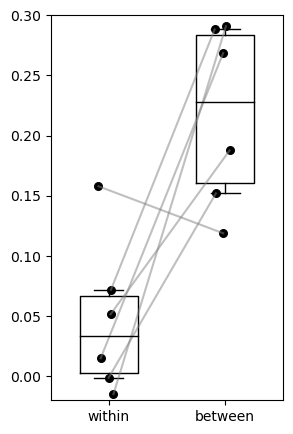

,Timepoint,Condition 1,Condition 2,Test Used,Statistic,p-value,Adjusted p-value (bonferroni),Significance,Effect Size,Effect Size Type,Mean Cond 1,Mean Cond 2,Mean Diff,SD Diff,N,Normal Dist.,Normality p-value
0,T1,C1,C2,t-test,-3.4743,0.0178,0.0178,*,-1.4184,Cohen's d,0.0467,0.2177,-0.171,0.1206,6,True,0.5928


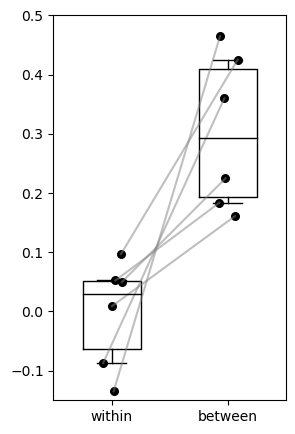

,Timepoint,Condition 1,Condition 2,Test Used,Statistic,p-value,Adjusted p-value (bonferroni),Significance,Effect Size,Effect Size Type,Mean Cond 1,Mean Cond 2,Mean Diff,SD Diff,N,Normal Dist.,Normality p-value
0,T1,C1,C2,t-test,-3.9675,0.0107,0.0107,*,-1.6197,Cohen's d,-0.0024,0.3032,-0.3056,0.1887,6,True,0.3046


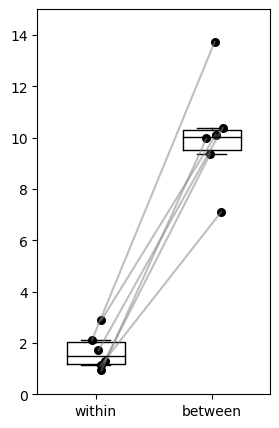

,Timepoint,Condition 1,Condition 2,Test Used,Statistic,p-value,Adjusted p-value (bonferroni),Significance,Effect Size,Effect Size Type,Mean Cond 1,Mean Cond 2,Mean Diff,SD Diff,N,Normal Dist.,Normality p-value
0,T1,C1,C2,t-test,-10.8181,0.0001,0.0001,***,-4.4165,Cohen's d,1.6777,10.1067,-8.4291,1.9086,6,True,0.8637


In [4]:


between_subspace = [data[3] for data in forward_data_pop_geometry_subspace]
within_subspace = [data[4] for data in forward_data_pop_geometry_subspace]

between_angles = [data[3] for data in forward_data_pop_geometry_angles]
within_angles = [data[4] for data in forward_data_pop_geometry_angles]

between_topology = [data[3] for data in forward_data_topology]
within_topology = [data[4] for data in forward_data_topology]

print_large('Subspace angles')
fig, ax = plt.subplots(figsize=(3, 5))
plots.boxplot_with_points_and_lines(np.hstack((within_subspace,between_subspace)), ['within','between'],ax, '', ylim=[-0.02, 0.3])
plt.show()
display(st.post_hoc_repeated_measures([np.vstack(within_subspace),np.vstack(between_subspace)]))


print_large('Edge angles')
fig, ax = plt.subplots(figsize=(3, 5))
plots.boxplot_with_points_and_lines(np.hstack((within_angles,between_angles)), ['within','between'],ax, '', ylim=[-0.15, 0.5])
plt.show()
display(st.post_hoc_repeated_measures([np.vstack(within_angles),np.vstack(between_angles)]))

print_large('Persistent homology')
fig, ax = plt.subplots(figsize=(3, 5))
plots.boxplot_with_points_and_lines(np.hstack((within_topology,between_topology)), ['within','between'],ax, '', ylim=[0, 15])
plt.show()
display(st.post_hoc_repeated_measures([np.vstack(within_topology),np.vstack(between_topology)]))